In [124]:
from collections import defaultdict
import numpy as np

def leaky_relu(arr, alpha=0.1, threshold=0.0):
    return np.where(arr > threshold, alpha * arr, arr)

def softmax(x):
    if np.sum(np.exp(x), axis=0) == 0:
        return np.exp(x) / 1
    else:
        return np.exp(x) / np.sum(np.exp(x), axis=0)

def minmax(x, i):
    return x[i] / (np.max(x) - np.min(x))

def predict(x, i, limit):
    limit = limit / (np.max(x) - np.min(x))
    votes = x[i] / (np.max(x) - np.min(x))

    # If limit is more than any of the votes, print Hurray
    #if limit <= np.max(votes):
        #print(f"Limit: {limit} Max: {np.max(votes)}")

    votes2 = leaky_relu(votes, alpha=1.5, threshold=limit)

    #if limit <= np.max(votes):
        #print(f"Votes: {votes2} Limit: {limit}")

    # If a vote is above the limit, enhance its vote by a factor of 10
    #votes = [x * 10 if x > limit else x for x in votes]
    return votes2

def soft_vote(*arrays, weights=None):
    # Convert the arrays to numpy arrays
    arrays = [np.array(arr) for arr in arrays]
    
    # Check if weights are provided, otherwise set equal weights
    if weights is None:
        weights = [1] * len(arrays)
    else:
        weights = np.array(weights)
    
    # Weighted average of the predicted probabilities
    soft_voting_result = np.average(arrays, axis=0, weights=weights)
    
    # Select the class with the highest average probability
    final_prediction = np.argmax(soft_voting_result)
    
    return final_prediction


def predict_team(X, limits, weights, i):
    # Get the votes for each candidate
    #votes = [predict(x, i) for x in X]

    # Include limits
    votes = [predict(x, i, limit) for x, limit in zip(X, limits)]

    #votes = [softmax(x) for x in votes]
    #votes = [x * weights[i] for i, x in enumerate(votes)]

    prediction = soft_vote(*votes, weights=weights)
    #prediction = average_probabilities(*votes, weights=weights)
    #prediction = ranked_voting(votes, weights=weights)

    #comb = np.sum(votes, axis=0)
    #prediction = np.argmax(comb, axis=0)
    return prediction

In [129]:
import numpy as np
from keras.datasets import cifar10

(X_train_org, Y_train), (X_test_org, Y_test) = cifar10.load_data()

Y_train = Y_train.reshape(Y_train.shape[0])
Y_test = Y_test.reshape(Y_test.shape[0])

# Base class sums
Y_ts_threshold = np.loadtxt("class_sums/CIFAR10AdaptiveThresholding_99_2000_500_10.0_10_32_1.txt", delimiter=",")
Y_ts_thermometer_3 = np.loadtxt("class_sums/CIFAR10ColorThermometers_99_2000_1500_2.5_3_8_32_1.txt", delimiter=",")
Y_ts_thermometer_4 = np.loadtxt("class_sums/CIFAR10ColorThermometers_99_2000_1500_2.5_4_8_32_1.txt", delimiter=",")
Y_ts_hog = np.loadtxt("class_sums/CIFAR10HistogramOfGradients_99_2000_50_10.0_0_32_0.txt", delimiter=",")

# New class sums
Y_ts_canny = np.loadtxt("class_sums/CIFAR10CannyHoughLines_100_2000_500_10.0_16_32_1.txt", delimiter=",")
Y_ts_otsu = np.loadtxt("class_sums/CIFAR10Otsu_100_2000_500_10.0_16_32_1.txt", delimiter=",")
Y_ts_thresh_inv = np.loadtxt("class_sums/CIFAR10ThresInvBlur_100_2000_500_10.0_16_32_1.txt", delimiter=",")
Y_ts_thermometer_2 = np.loadtxt("class_sums/CIFAR102x2ColorThermometers_100_2000_1500_2.5_2_32_1.txt", delimiter=",")
Y_ts_thermometer_5 = np.loadtxt("class_sums/CIFAR105x5ColorThermometers_100_2000_1500_2.5_5_32_1.txt", delimiter=",")

experts = [
    Y_ts_hog,
    Y_ts_thermometer_4,
    Y_ts_thermometer_3,
    Y_ts_threshold,
    Y_ts_thermometer_5,
    Y_ts_thermometer_2,
    Y_ts_thresh_inv,
    Y_ts_otsu,
    Y_ts_canny
]

# Limit class sums for each expert
#limits = [60,4300,4700,2100,4400,4500,2300,1900,2800]
limits = [50,3400,3600,1500,3300,3500,1700,1600,1800]
#limits = [40, 2800, 2800, 1200, 2600, 3000, 1400, 1400, 1600]

# Weights for each expert
#weights = [4, 2, 2, 2, 1, 1, 1, 0.6, 0.6]
weights = [0.6353, 0.6272, 0.6212, 0.5701, 0.5754, 0.5672, 0.4908, 0.4291, 0.3952]
weights = [x * 100 for x in weights]

# Variables for accuracy and plotting
predicted_values = np.zeros(Y_test.shape, dtype=np.int32)

correct = 0
total = 0
exps = 0

# To beat: 75.1
# Current best: 76.3

for i in range(Y_ts_threshold.shape[0]):
#for i in range(5):
    total += 1

    vote = predict_team(experts, limits, weights, i)

    predicted_values[i] = vote

    if vote == Y_test[i]:
        correct += 1

print("Team Accuracy: %.1f" % (100 * (correct / total )))
print(f"Correct: {correct}, Total: {total}, Incorrent: {total - correct}")

Team Accuracy: 75.3
Correct: 7528, Total: 10000, Incorrent: 2472


**Argmax + Weights**

Team Accuracy: 76.3
Correct: 7627, Total: 10000, Incorrent: 2373

**SoftVote + Weights**

Team Accuracy: 76.3
Correct: 7627, Total: 10000, Incorrent: 2373

**Average Probabilities + Weights**

Team Accuracy: 76.3
Correct: 7627, Total: 10000, Incorrent: 2373

**Ranked Voting + Weights + Softmax**

Team Accuracy: 76.1
Correct: 7613, Total: 10000, Incorrent: 2387

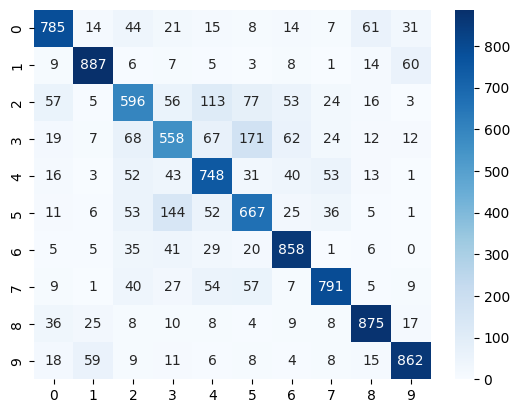

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn

# Ensure the arrays are numpy arrays
Y_test = np.array(Y_test)
predicted_values = np.array(predicted_values)
 
matrix = confusion_matrix(Y_test, predicted_values)

heatmap = seaborn.heatmap(matrix, annot=True, fmt='g', cmap='Blues')
 
figure = heatmap.get_figure()
figure.savefig("cm_team.png", dpi=400)

# Calculate  the average value in Y_ts_threshold in each class
average_values = np.zeros((10, 2), dtype=np.float32)

sums = np.zeros(10, dtype=np.float32)

for i in range(Y_ts_threshold.shape[0]):
    for j in range(10):
        sums[j] += Y_ts_threshold[i][j]
    
#print(sums / Y_ts_threshold.shape[0])
#print(average_values)

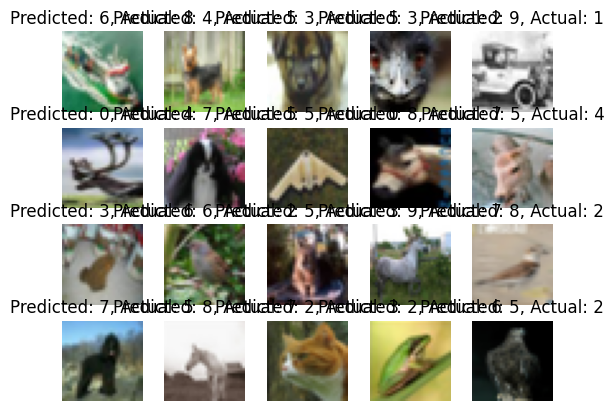

In [21]:
# Plot 20 of the incorrect predictions

import matplotlib.pyplot as plt

incorrect = np.where(predicted_values != Y_test)[0]

for i in range(20):
    index = incorrect[i]
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_test_org[index])
    plt.title(f"Predicted: {predicted_values[index]}, Actual: {Y_test[index]}")
    plt.axis('off')

plt.show()